In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cmaps
from matplotlib.colors import LinearSegmentedColormap

In [7]:
# from importlib import reload
# reload(rw)
import roms_workspace as rw
import scipy as sci
import os
##========================================================================##
#  Stick to the guideline of beginning with the simplest approach,
#  only sea surface temperature (SST) was assimilated, and only
#  initial condition was adjusted.
#  Here we first validated the performance of ROMS I4D-VAR configured
#  in this strategy.
##========================================================================##
my_rootnl = '/Volumes/WD_3/'
my_rootda = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs'
nl_workspace_info = {
                     # 'run04/outputs':'FORWARD',
                     'outputs_SCORRECTION/outputs_201205':'Forward v4 scorrection',
                    # 'run17_v4/outputs':'FORWARD drggrd',
                     }
da_workspace_info = {
                     # 'workspace':'Adj ALL',
                     
                     'workspace_geopolarsst':'Assimilate geopolar sst',
                     'workspace_acsposst': 'Assimilate acspo sst',
                     # 'workspace03_nud_3d_b12hr':'Adj INI 12hr begin',
                     # 'workspace03_nud_2d':'NUD+Adj INI',
                     # 'workspace03_nud_3d':'NUD+Adj INI+3DAY',
            
                     }

var = 'salt'
areas = {
         'bh': ('Bohai Sea', [0,7]),
        'ys': ('Yellow Sea', [6.5,11]),
        'cre': ('Changjiang River Estuary',[10.5,14.5]),
        'ks': ('Kuroshio Current System', [21.5,24]),
        'all': ('East China Sea', [10,25])
}

nl_Vars = {}
nl_Workspaces = []
for i in range(len(nl_workspace_info)):
    nl_Workspaces.append(rw.Nl_workspace( MY_ROOT         =my_rootnl,
                                    workspace_name  =list(nl_workspace_info.keys())[i],
                                    workspace_detail=list(nl_workspace_info.values())[i]
                                   ))
    nl_Workspaces[i].load_mtfroms(isAna=False,Surf=True)


dab_Vars = {}
dab_Workspaces = []
for i in range(len(da_workspace_info)):
    dab_Workspaces.append(rw.Da_workspace(MY_ROOT         =my_rootda, 
                                    workspace_name  = list(da_workspace_info.keys())[i],
                                    workspace_detail= list(da_workspace_info.values())[i]
                                   ))
    dab_Workspaces[i].load_mtfroms(isAna=False, Surf=True)

daa_Vars = {}
daa_Workspaces = []
for i in range(len(da_workspace_info)):
    daa_Workspaces.append(rw.Da_workspace(MY_ROOT         =my_rootda, 
                                    workspace_name  = list(da_workspace_info.keys())[i],
                                    workspace_detail= list(da_workspace_info.values())[i]
                                   ))
    daa_Workspaces[i].load_mtfroms(isAna=True, Surf=True)

obs_ds = xr.open_dataset(os.path.join(my_rootda,
                                      'NOAA_GHRSST',
                                      'geopolar_sst_201205.nc'
                                      ))
# obs_time = obs_ds.obs_time.data.astype('float')/86400/1e9
obs_time = obs_ds.obs_time.data
obs_value = obs_ds.obs_value.data
obs_lon = obs_ds.obs_lon.data
obs_lat = obs_ds.obs_lat.data
obs_Vars = {} 
area_index={}
obs_inarea ={}
# area iteration 
for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        print('loading %s in %s  area...'%(var,area))
        if iw == 0:
            nl_Vars[area] = []
        # loading data from FORWARD model outputs
        nl_Vars[area].append(nl_Workspaces[iw].pull_var2d(varname=         var, area=area,time_range=('2012-05-01','2012-05-07')))
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):
        print('loading %s in %s  area...'%(var,area))
        if iw == 0:
            
            dab_Vars[area] = []
            daa_Vars[area] = []
        
        
        # loading data from prior outputs

        dab_Vars[area].append(dab_Workspaces[iw].pull_var2d(varname='%s_sur'%var, area=area,time_range=('2012-05-01','2012-05-07')))
        # loading data from posterior outputs
        daa_Vars[area].append(daa_Workspaces[iw].pull_var2d(varname='%s_sur'%var, area=area,time_range=('2012-05-01','2012-05-07')))

        #================================extrapolate observation data to model grid================================
        index_insea = np.where(~np.isnan(daa_Vars[area][0].value[0,:,:]))
        obs_Vars[area] = np.zeros(
                                [len(obs_ds.survey_time.data), 
                                 len(index_insea[0])]
                                ) 
        # for itime, itime_obs in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9): # for matlab obs file
        for itime, itime_obs in enumerate(obs_ds.survey_time.data):
            index_thistime = np.where(obs_time == itime_obs)[0]
            obs_Vars[area][itime,:] = sci.interpolate.griddata(
                                                               np.c_[obs_lon[index_thistime],
                                                                    obs_lat[index_thistime]],
                                                               obs_value[index_thistime],
                                                               np.c_[daa_Vars[area][0].lon[index_insea],
                                                                     daa_Vars[area][0].lat[index_insea]],
                                                               method ='nearest')
        #==========================================================================================================
        # note that it's more resonable to interp model data to observation location 
        # since model grider is finer than observaion resolution
        #==========================================================================================================


Workspace: /Volumes/WD_3/outputs_SCORRECTION/outputs_201205
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_geopolarsst
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_acsposst
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_geopolarsst
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_acsposst
loading salt in bh  area...
loading salt in ys  area...
loading salt in cre  area...
loading salt in ks  area...
loading salt in all  area...
loading salt in bh  area...
loading salt in ys  area...
loading salt in cre  area...
loading salt in ks  area...
loading salt in all  area...
loading salt in bh  area...
loading salt in ys  area...
loading salt in cre  area...
loading salt in ks  area...
loading salt in all  area...


In [15]:
obs_lat[np.where(obs_time == 15451.5)[0]].shape

(0,)

In [16]:
#================================calculate area-mean sst at observation location================================
# FORWARD model
obs_location = np.c_[
                     obs_lon[np.where(obs_time == 15461.5)[0]],
                     obs_lat[np.where(obs_time == 15461.5)[0]]
                    ]


for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        nl_Vars[area][iw].val_obsgrd   = np.zeros([len( nl_Vars[area][iw].ocean_time), len(obs_location)])
        for i in range(1):
        
            nl_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[nl_Vars[area][iw].lon.ravel(),
                                                                            nl_Vars[area][iw].lat.ravel()],
                                                                      nl_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                 )
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):



        dab_Vars[area][iw].val_obsgrd  = np.zeros([len(dab_Vars[area][iw].ocean_time), len(obs_location)])

        daa_Vars[area][iw].val_obsgrd  = np.zeros([len(daa_Vars[area][iw].ocean_time), len(obs_location)])



        for i in  range(1):
            dab_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[dab_Vars[area][iw].lon.ravel(),
                                                                            dab_Vars[area][iw].lat.ravel()],
                                                                      dab_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                      )

        for i in  range(1):
            daa_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[daa_Vars[area][iw].lon.ravel(),
                                                                            daa_Vars[area][iw].lat.ravel()],
                                                                      daa_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                      )
for area in list(areas.keys()):
    area_index[area] = np.where(~np.isnan(daa_Vars[area][0].val_obsgrd[0,:]))
   
    obs_inarea[area] = np.zeros([30,len(area_index[area][0])])*np.NAN
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]x
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[area][0]] for it,itime in enumerate(obs_ds.survey_time.data)]

    
for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        nl_Vars[area][iw].val_obsgrd   = np.zeros([len( nl_Vars[area][iw].ocean_time), len(obs_location)])
        for i, itime_nl in enumerate(nl_Vars[area][iw].ocean_time):
        
            nl_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[nl_Vars[area][iw].lon.ravel(),
                                                                            nl_Vars[area][iw].lat.ravel()],
                                                                      nl_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                     method ='nearest')
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):



        dab_Vars[area][iw].val_obsgrd  = np.zeros([len(dab_Vars[area][iw].ocean_time), len(obs_location)])

        daa_Vars[area][iw].val_obsgrd  = np.zeros([len(daa_Vars[area][iw].ocean_time), len(obs_location)])



        for i, itime_daa in enumerate(dab_Vars[area][iw].ocean_time):
            dab_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[dab_Vars[area][iw].lon.ravel(),
                                                                            dab_Vars[area][iw].lat.ravel()],
                                                                      dab_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                      method ='nearest')

        for i, itime_daa in enumerate(daa_Vars[area][iw].ocean_time):
            daa_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[daa_Vars[area][iw].lon.ravel(),
                                                                            daa_Vars[area][iw].lat.ravel()],
                                                                      daa_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                      method ='nearest')


In [24]:
daa_Vars['bh'][0].ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 145)>
array(['2012-05-01T00:00:00.000000000', '2012-05-01T01:00:00.000000000',
       '2012-05-01T02:00:00.000000000', '2012-05-01T03:00:00.000000000',
       '2012-05-01T04:00:00.000000000', '2012-05-01T05:00:00.000000000',
       '2012-05-01T06:00:00.000000000', '2012-05-01T07:00:00.000000000',
       '2012-05-01T08:00:00.000000000', '2012-05-01T09:00:00.000000000',
       '2012-05-01T10:00:00.000000000', '2012-05-01T11:00:00.000000000',
       '2012-05-01T12:00:00.000000000', '2012-05-01T13:00:00.000000000',
       '2012-05-01T14:00:00.000000000', '2012-05-01T15:00:00.000000000',
       '2012-05-01T16:00:00.000000000', '2012-05-01T17:00:00.000000000',
       '2012-05-01T18:00:00.000000000', '2012-05-01T19:00:00.000000000',
       '2012-05-01T20:00:00.000000000', '2012-05-01T21:00:00.000000000',
       '2012-05-01T22:00:00.000000000', '2012-05-01T23:00:00.000000000',
       '2012-05-02T00:00:00.000000000', '2012-05-02T01:00:00.000000000',
       '2012-05-02T02:00:00.000000000', '2012-05-02T03:00:00.000000000',
       '2012-05-02T04:00:00.000000000', '2012-05-02T05:00:00.000000000',
       '2012-05-02T06:00:00.000000000', '2012-05-02T07:00:00.000000000',
       '2012-05-02T08:00:00.000000000', '2012-05-02T09:00:00.000000000',
       '2012-05-02T10:00:00.000000000', '2012-05-02T11:00:00.000000000',
       '2012-05-02T12:00:00.000000000', '2012-05-02T13:00:00.000000000',
       '2012-05-02T14:00:00.000000000', '2012-05-02T15:00:00.000000000',
       '2012-05-02T16:00:00.000000000', '2012-05-02T17:00:00.000000000',
       '2012-05-02T18:00:00.000000000', '2012-05-02T19:00:00.000000000',
       '2012-05-02T20:00:00.000000000', '2012-05-02T21:00:00.000000000',
       '2012-05-02T22:00:00.000000000', '2012-05-02T23:00:00.000000000',
       '2012-05-03T00:00:00.000000000', '2012-05-03T01:00:00.000000000',
       '2012-05-03T02:00:00.000000000', '2012-05-03T03:00:00.000000000',
       '2012-05-03T04:00:00.000000000', '2012-05-03T05:00:00.000000000',
       '2012-05-03T06:00:00.000000000', '2012-05-03T07:00:00.000000000',
       '2012-05-03T08:00:00.000000000', '2012-05-03T09:00:00.000000000',
       '2012-05-03T10:00:00.000000000', '2012-05-03T11:00:00.000000000',
       '2012-05-03T12:00:00.000000000', '2012-05-03T13:00:00.000000000',
       '2012-05-03T14:00:00.000000000', '2012-05-03T15:00:00.000000000',
       '2012-05-03T16:00:00.000000000', '2012-05-03T17:00:00.000000000',
       '2012-05-03T18:00:00.000000000', '2012-05-03T19:00:00.000000000',
       '2012-05-03T20:00:00.000000000', '2012-05-03T21:00:00.000000000',
       '2012-05-03T22:00:00.000000000', '2012-05-03T23:00:00.000000000',
       '2012-05-04T00:00:00.000000000', '2012-05-04T01:00:00.000000000',
       '2012-05-04T02:00:00.000000000', '2012-05-04T03:00:00.000000000',
       '2012-05-04T04:00:00.000000000', '2012-05-04T05:00:00.000000000',
       '2012-05-04T06:00:00.000000000', '2012-05-04T07:00:00.000000000',
       '2012-05-04T08:00:00.000000000', '2012-05-04T09:00:00.000000000',
       '2012-05-04T10:00:00.000000000', '2012-05-04T11:00:00.000000000',
       '2012-05-04T12:00:00.000000000', '2012-05-04T13:00:00.000000000',
       '2012-05-04T14:00:00.000000000', '2012-05-04T15:00:00.000000000',
       '2012-05-04T16:00:00.000000000', '2012-05-04T17:00:00.000000000',
       '2012-05-04T18:00:00.000000000', '2012-05-04T19:00:00.000000000',
       '2012-05-04T20:00:00.000000000', '2012-05-04T21:00:00.000000000',
       '2012-05-04T22:00:00.000000000', '2012-05-04T23:00:00.000000000',
       '2012-05-05T00:00:00.000000000', '2012-05-05T01:00:00.000000000',
       '2012-05-05T02:00:00.000000000', '2012-05-05T03:00:00.000000000',
       '2012-05-05T04:00:00.000000000', '2012-05-05T05:00:00.000000000',
       '2012-05-05T06:00:00.000000000', '2012-05-05T07:00:00.000000000',
       '2012-05-05T08:00:00.000000000', '2012-05-05T09:00:00.000000000',
       '2012-05-05T10:00:00.000000000', '2012-05-05T11:00:00.000000000',
       '

In [25]:
areas = {
         'bh': ('Bohai Sea', [-0.5,7.5]),
        'ys': ('Yellow Sea', [6.5,11]),
        'cre': ('Changjiang River Estuary',[12,16.5]),
        'ks': ('Kuroshio Current System', [22.,24.5]),
        'all': ('East China Sea', [10,25])
}
timemean_obs = {}
timemean_dab = {}
timemean_daa = {}
timemean_nl = {}

timemean_ddab = {}
timemean_ddaa = {}
timemean_dnl = {}

onobstime_dab = {}
onobstime_daa = {}
onobstime_nl = {}

onobstime_ddab = {}
onobstime_ddaa = {}
onobstime_dnl = {}

    
    
for area in list(areas.keys()):
    timemean_nl[area] = []
    timemean_dnl[area] = []
    onobstime_nl[area] = []
    onobstime_dnl[area] = []
    for iw in range(len((nl_workspace_info))):
        for it in range(len(obs_ds.survey_time.data)):
            if it == 0:
                timemean_nl[area].append(0.5*(nl_Vars[area][iw].val_obsgrd[it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[1+it,area_index[area]]))
                timemean_dnl[area].append(0.5*(nl_Vars[area][iw].val_obsgrd[it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[1+it,area_index[area]]) - \
                                  obs_inarea[area][it][:])
                
                onobstime_nl[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_dnl[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
            else:
                timemean_nl[area][iw]   += 0.5*(nl_Vars[area][iw].val_obsgrd[it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[1+it,area_index[area]])
                timemean_dnl[area][iw] += 0.5*(nl_Vars[area][iw].val_obsgrd[it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[1+it,area_index[area]]) -  \
                                  obs_inarea[area][it][:]
            
            onobstime_nl[area][iw][it,:] =  0.5*(nl_Vars[area][iw].val_obsgrd[it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[1+it,area_index[area]])
            onobstime_dnl[area][iw][it,:] = 0.5*(nl_Vars[area][iw].val_obsgrd[it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[1+it,area_index[area]]) -  \
                                  obs_inarea[area][it][:]
            
        timemean_nl[area][iw]  = timemean_nl[area][iw]/len(obs_ds.survey_time.data)
        timemean_dnl[area][iw] = timemean_dnl[area][iw] /len(obs_ds.survey_time.data)
        
    
    
    
    
for area in list(areas.keys()):
        
    timemean_dab[area] = []
    timemean_daa[area] = []

    timemean_ddab[area] = []
    timemean_ddaa[area] = []

    onobstime_dab[area] = []
    onobstime_daa[area] = []

    onobstime_ddab[area] = []
    onobstime_ddaa[area] = []
    for iw in range(len((da_workspace_info))):   
        for it in range(len(obs_ds.survey_time.data)):
            if it == 0:
                timemean_obs[area] = obs_inarea[area][it][:].copy()
                timemean_dab[area].append(dab_Vars[area][iw].val_obsgrd[it,area_index[area]].copy())
                timemean_daa[area].append(daa_Vars[area][iw].val_obsgrd[it,area_index[area]].copy())


                timemean_ddab[area].append(dab_Vars[area][iw].val_obsgrd[it,area_index[area]] - \
                                      obs_inarea[area][it][:])
                timemean_ddaa[area].append(daa_Vars[area][iw].val_obsgrd[it,area_index[area]] - \
                                      obs_inarea[area][it][:])


                onobstime_dab[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_daa[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))


                onobstime_ddab[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_ddaa[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))



            else:
                timemean_obs[area]  += obs_inarea[area][it][:].copy()
                timemean_dab[area][iw]  += dab_Vars[area][iw].val_obsgrd[it,area_index[area]].copy()
                timemean_daa[area][iw]  += daa_Vars[area][iw].val_obsgrd[it,area_index[area]].copy()


                timemean_ddab[area][iw] += dab_Vars[area][iw].val_obsgrd[it,area_index[area]] - \
                                      obs_inarea[area][it][:]
                timemean_ddaa[area][iw] += daa_Vars[area][iw].val_obsgrd[it,area_index[area]] - \
                                      obs_inarea[area][it][:]


            onobstime_dab[area][iw][it,:] = dab_Vars[area][iw].val_obsgrd[it,area_index[area]].copy()
            onobstime_daa[area][iw][it,:] =daa_Vars[area][iw].val_obsgrd[it,area_index[area]].copy()


            onobstime_ddab[area][iw][it,:] = dab_Vars[area][iw].val_obsgrd[it,area_index[area]] - \
                                      obs_inarea[area][it][:]
            onobstime_ddaa[area][iw][it,:] = daa_Vars[area][iw].val_obsgrd[it,area_index[area]] - \
                                      obs_inarea[area][it][:]



        timemean_obs[area] = timemean_obs[area]/len(obs_ds.survey_time.data)
        timemean_dab[area][iw] = timemean_dab[area][iw]/len(obs_ds.survey_time.data)
        timemean_daa[area][iw] = timemean_daa[area][iw]/len(obs_ds.survey_time.data)

        
        timemean_ddab[area][iw] = timemean_ddab[area][iw]/len(obs_ds.survey_time.data)
        timemean_ddaa[area][iw] = timemean_ddaa[area][iw]/len(obs_ds.survey_time.data)
        


In [26]:
areas = {
         'bh': ('Bohai Sea', [-0.5,7.5]),
        'ys': ('Yellow Sea', [6.5,11]),
        'cre': ('Changjiang River Estuary',[12,16.5]),
        'ks': ('Kuroshio Current System', [22.,24.5]),
        'all': ('East China Sea', [10,25])
}
timemean_obs = {}
timemean_dab = {}
timemean_daa = {}
timemean_nl = {}

timemean_ddab = {}
timemean_ddaa = {}
timemean_dnl = {}

onobstime_dab = {}
onobstime_daa = {}
onobstime_nl = {}

onobstime_ddab = {}
onobstime_ddaa = {}
onobstime_dnl = {}

time_ref = [0, 0,]
    
for area in list(areas.keys()):
    timemean_nl[area] = []
    timemean_dnl[area] = []
    onobstime_nl[area] = []
    onobstime_dnl[area] = []
    for iw in range(len((nl_workspace_info))):
        for it in range(len(obs_ds.survey_time.data)):
            if it == 0:
                timemean_nl[area].append(0.5*(nl_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[(time_ref[iw]+1)+it,area_index[area]]))
                timemean_dnl[area].append(0.5*(nl_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[(time_ref[iw]+1)+it,area_index[area]]) - \
                                  obs_inarea[area][it][:])
                
                onobstime_nl[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_dnl[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
            else:
                timemean_nl[area][iw]   += 0.5*(nl_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[(time_ref[iw]+1)+it,area_index[area]])
                timemean_dnl[area][iw] += 0.5*(nl_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[(time_ref[iw]+1)+it,area_index[area]]) -  \
                                  obs_inarea[area][it][:]
            
            onobstime_nl[area][iw][it,:] =  0.5*(nl_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[(time_ref[iw]+1)+it,area_index[area]])
            onobstime_dnl[area][iw][it,:] = 0.5*(nl_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] + \
                                     nl_Vars[area][iw].val_obsgrd[(time_ref[iw]+1)+it,area_index[area]]) -  \
                                  obs_inarea[area][it][:]
            
        timemean_nl[area][iw]  = timemean_nl[area][iw]/len(obs_ds.survey_time.data)
        timemean_dnl[area][iw] = timemean_dnl[area][iw] /len(obs_ds.survey_time.data)
        
    
    
    
    
for area in list(areas.keys()):
        
    timemean_dab[area] = []
    timemean_daa[area] = []

    timemean_ddab[area] = []
    timemean_ddaa[area] = []

    onobstime_dab[area] = []
    onobstime_daa[area] = []

    onobstime_ddab[area] = []
    onobstime_ddaa[area] = []
    for iw in range(len((da_workspace_info))):   
        for it in range(len(obs_ds.survey_time.data)):
            if it == 0:
                timemean_obs[area] = obs_inarea[area][it][:].copy()
                timemean_dab[area].append(dab_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]].copy())
                timemean_daa[area].append(daa_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]].copy())


                timemean_ddab[area].append(dab_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] - \
                                      obs_inarea[area][it][:])
                timemean_ddaa[area].append(daa_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] - \
                                      obs_inarea[area][it][:])


                onobstime_dab[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_daa[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))


                onobstime_ddab[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_ddaa[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))



            else:
                timemean_obs[area]  += obs_inarea[area][it][:].copy()
                timemean_dab[area][iw]  += dab_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]].copy()
                timemean_daa[area][iw]  += daa_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]].copy()


                timemean_ddab[area][iw] += dab_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] - \
                                      obs_inarea[area][it][:]
                timemean_ddaa[area][iw] += daa_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] - \
                                      obs_inarea[area][it][:]


            onobstime_dab[area][iw][it,:] = dab_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]].copy()
            onobstime_daa[area][iw][it,:] =daa_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]].copy()


            onobstime_ddab[area][iw][it,:] = dab_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] - \
                                      obs_inarea[area][it][:]
            onobstime_ddaa[area][iw][it,:] = daa_Vars[area][iw].val_obsgrd[time_ref[iw]+it,area_index[area]] - \
                                      obs_inarea[area][it][:]



        timemean_obs[area] = timemean_obs[area]/len(obs_ds.survey_time.data)
        timemean_dab[area][iw] = timemean_dab[area][iw]/len(obs_ds.survey_time.data)
        timemean_daa[area][iw] = timemean_daa[area][iw]/len(obs_ds.survey_time.data)

        
        timemean_ddab[area][iw] = timemean_ddab[area][iw]/len(obs_ds.survey_time.data)
        timemean_ddaa[area][iw] = timemean_ddaa[area][iw]/len(obs_ds.survey_time.data)
        


In [32]:
np.nanmean(onobstime_dnl[area][0],axis=1)

array([10.69671737, 10.68335103, 10.67072588, 10.5448531 , 10.23990813,
       10.13346478,  9.99208358,  9.95928527, 10.07524618, 10.18691124,
       10.19243759, 10.09897565,  9.96298638, 10.01174584,  9.97153587,
        9.84478774,  9.62226136,  9.4538764 ,  9.49953452,  9.78494561,
        9.92666892,  9.58968653,  9.34700723,  9.37299443,  9.20019098,
        9.40373837,  9.24599851,  9.06804978,  9.15082447,  9.13860766,
        8.88632695])

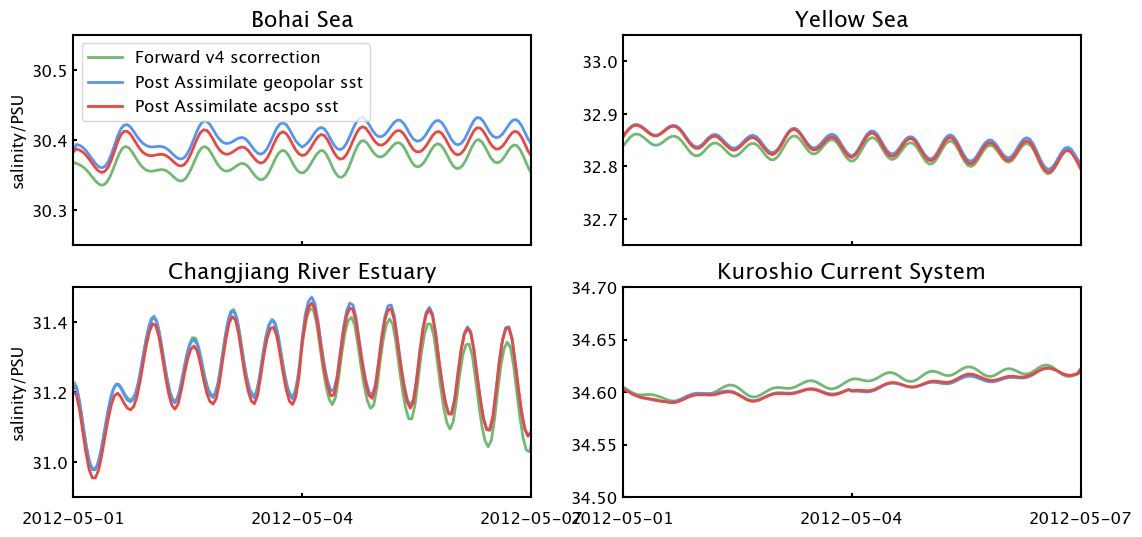

In [103]:
areas = {
         'bh': ('Bohai Sea', [30.25,30.55]),
        'ys': ('Yellow Sea', [32.65,33.05]),
        'cre': ('Changjiang River Estuary',[30.9,31.5]),
        'ks': ('Kuroshio Current System', [34.5,34.7])
}
#====================================Calculate on observation grid
plt.rcParams['font.family'] = 'Lucida Grande'
# colorarray = cmaps.GMT_haxby.colors[:][:-8]
# nl_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,4)).astype(int)]
# colorarray = cmaps.cmocean_algae.colors[:][50:]
# daa_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,5)).astype(int)]
colorarray =   np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                ])/255
colorarray_blue = np.zeros([256,3])
for i in range(3):
    colorarray_blue[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
dab_color= [colorarray_blue[i,:] for i in np.ceil(np.linspace(0,len(colorarray_blue)-20,4)).astype(int)]

colorarray =   np.array(  [
                 [117,20,12],
                [140,26,17],
                [164,33,21],
                [188,39,26],
                [212,45,31],
                [233,52,37],
                [235,76,67],
                [233,52,37],
                [235,76,67],
                [237,117,113],
                [242,164,162]
                ])/255
colorarray_red = np.zeros([256,3])
for i in range(3):
    colorarray_red[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
daa_color= [colorarray_red[i,:] for i in np.ceil(np.linspace(0,len(colorarray_red)-20,4)).astype(int)]


colorarray_oran = cmaps.MPL_PRGn_r.colors[:63][:]
nl_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]

# colorarray_pi = cmaps.MPL_PRGn_r.colors[:63][:]
# dab_color= [colorarray_pi[i][:] for i in np.ceil(np.linspace(0,len(colorarray_pi)-1,4)).astype(int)]

iwnl = 0
iwda = 0
# obs_inarea = {}
fig = plt.figure(figsize=(13,6))
fig.tight_layout(pad=5.)
for i, (area, areainfo) in enumerate(areas.items()):
    ax = fig.add_subplot(2,2,i+1)
    
    for bnd in ax.spines.keys():
                            ax.spines[bnd].set_linewidth('1.5')
#     area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
   
#     obs_inarea[area] = np.zeros([30,len(area_index[0])])
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]
    # l1, =ax.plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(obs_inarea[area],axis=1),linewidth = 2.5,color = 'k',marker= '.',label = 'Observation')
    l2, =ax.plot(nl_Vars[area][iwnl].ocean_time,np.nanmean(nl_Vars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2,color = nl_color[2],label = nl_Workspaces[iwnl].workspace_detail)
    # l3, =ax.plot(dab_Vars[area][iwda].ocean_time,np.nanmean(dab_Vars[area][iwda].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 # linewidth = 2, color = dab_color[2], label = 'Prior '+ dab_Workspaces[iwda].workspace_detail)
    l3,=ax.plot(daa_Vars[area][iwda].ocean_time,np.nanmean(daa_Vars[area][iwda].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2, color = dab_color[2], label = 'Post '+ daa_Workspaces[iwda].workspace_detail)

    l4, =ax.plot(daa_Vars[area][iwda+1].ocean_time,np.nanmean(daa_Vars[area][iwda+1].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2, color = daa_color[2], label = 'Post '+ daa_Workspaces[iwda+1].workspace_detail)
   
    ax.set_xticks(daa_Vars[area][iwda].ocean_time[0::24*3])
    ax.set_xlim([daa_Vars[area][iwda].ocean_time[0],
                 daa_Vars[area][iwda].ocean_time[-1]])
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'in', length = 3, width = 1.5, labelsize = 12)
    # ax.set_ylim([0,8])
    
    if i+1 == 1 or i+1 == 2:
        ax.tick_params('x',labelbottom=False)
    
    ax.tick_params('x',pad=10)
    
    ax.set_title('%s' %areainfo[0],fontsize =16)
    ax.set_ylim(areainfo[1])
    if i +1 ==3 or i+1 ==1: ax.set_ylabel('salinity/PSU',fontsize = 12)
    
#     ax1={}
#     if i+ 1 == 1:
#         ax1[i] = fig.add_axes([0.125,0.537,0.353,0.1])
#         ax1[i].set_ylim([-0.1,0.1])
#         ax1[i].set_yticks([-0.1,0,0.1])
#     elif i+1 ==2:
#         ax1[i] = fig.add_axes([0.547,0.537,0.353,0.1])
#         ax1[i].set_ylim([-0.2,0.2])
#         ax1[i].set_yticks([-0.2,0,0.2])
#     elif i+1 ==3:
#         ax1[i] = fig.add_axes([0.125,0.125,0.353,0.1])
#         ax1[i].set_ylim([-0.5,0.5])
#         ax1[i].set_yticks([-0.5,0,0.5])
#     elif i+1 ==4:
#         ax1[i] = fig.add_axes([0.547,0.125,0.353,0.1])
#         ax1[i].set_ylim([-0.1,0.1])
#         ax1[i].set_yticks([-0.1,0,0.1])
    
#     for bnd in ax1[i].spines.keys():
#             ax1[i].spines[bnd].set_visible(False)
#     # ax1[i].plot(daa_Vars[area].ocean_time,np.nanmean(daa_Vars[area].val_obsgrd[:,area_index[area][0]],axis=(1))*0,alpha=0)
#     l5, =ax1[i].plot(obs_ds.survey_time,
#                      np.nanmean(onobstime_dnl[area][0],axis=1),
#                      linewidth =2,color= nl_color[3],marker= '.',label = 'Innovation FORWARD')
#     l6, =ax1[i].plot(obs_ds.survey_time,
#                      np.nanmean(onobstime_dab[area][iwda],axis=1)-
#                      np.nanmean(onobstime_nl[area][iwnl],axis=1),
#                      linewidth =2,color= dab_color[3],marker= '.',label = 'Difference Prior')
   
#     # l7, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
#     #                  np.nanmean(onobstime_daa[area][iwda],axis=1)-
#     #                  np.nanmean(onobstime_nl[area][iwnl],axis=1),
#     #                  linewidth =2,color= daa_color[3],marker= '.',label = 'Difference Post')
    
#     l7, =ax1[i].plot(daa_Vars[area][iwda].ocean_time[1:],
#                      np.nanmean(dab_Vars[area][iwda].value[1:,:,:]-
#                            np.array(
#                                [0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]) 
#                                 for it in range(1,len(daa_Vars[area][iwda].ocean_time))]) ,axis = (1,2)
#                                    ),
#                      linewidth =2,color= daa_color[3],label = 'Difference Post')
   

#     ax1[i].tick_params('x',labelbottom=False)
#     ax1[i].tick_params('y',labelleft=False,labelright=True)
#     ax1[i].tick_params(direction='in',bottom =0, left = 0,right = 1,length = 3, width = 1.5)
#     ax1[i].set_xticks(daa_Vars[area][iwda].ocean_time[0::240])
#     ax1[i].set_xlim([daa_Vars[area][iwda].ocean_time[0],
#                  daa_Vars[area][iwda].ocean_time[-1]])
#     ax1[i].set_facecolor('none')
    if i+1 ==1 : ax.legend(handles=[l2,l3,l4],fontsize=12)
    # if i +1 ==2 or i+1 ==4: ax1[i].set_ylabel('temp/$\degree$C')
plt.savefig('./dasst_sss_contrast.pdf',bbox_inches='tight')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.pdf',bbox_inches='tight')
# plt.savefig('./fig_evolution/exp_adj_ini/post/sss/roms_i4dvar_contrast_sss_adj_ini.jpeg',dpi=1200,bbox_inches='tight')

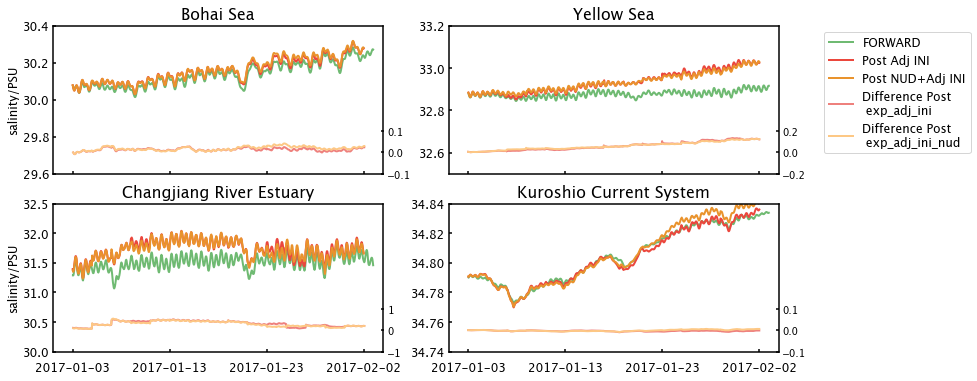

In [42]:
areas = {
         'bh': ('Bohai Sea', [29.6,30.4]),
        'ys': ('Yellow Sea', [32.5,33.2]),
        'cre': ('Changjiang River Estuary',[30,32.5]),
        'ks': ('Kuroshio Current System', [34.74,34.84])
}
#====================================Calculate on observation grid
plt.rcParams['font.family'] = 'Lucida Grande'
# colorarray = cmaps.GMT_haxby.colors[:][:-8]
# nl_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,4)).astype(int)]
# colorarray = cmaps.cmocean_algae.colors[:][50:]
# daa_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,5)).astype(int)]
colorarray =   np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                ])/255
colorarray_blue = np.zeros([256,3])
for i in range(3):
    colorarray_blue[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
dab_color= [colorarray_blue[i,:] for i in np.ceil(np.linspace(0,len(colorarray_blue)-20,4)).astype(int)]

colorarray =   np.array(  [
                 [117,20,12],
                [140,26,17],
                [164,33,21],
                [188,39,26],
                [212,45,31],
                [233,52,37],
                [235,76,67],
                [233,52,37],
                [235,76,67],
                [237,117,113],
                [242,164,162]
                ])/255
colorarray_red = np.zeros([256,3])
for i in range(3):
    colorarray_red[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
daa_color= [colorarray_red[i,:] for i in np.ceil(np.linspace(0,len(colorarray_red)-20,4)).astype(int)]

colorarray_oran = cmaps.MPL_PuOr.colors[:63][:]
daa2_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]
colorarray_oran = cmaps.MPL_PRGn_r.colors[:63][:]
nl_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]

# colorarray_pi = cmaps.MPL_PRGn_r.colors[:63][:]
# dab_color= [colorarray_pi[i][:] for i in np.ceil(np.linspace(0,len(colorarray_pi)-1,4)).astype(int)]

iwnl = 0
iwda = 0
iwda1 =2
# obs_inarea = {}
fig = plt.figure(figsize=(13,6))
fig.tight_layout(pad=5.)
for i, (area, areainfo) in enumerate(areas.items()):
    ax = fig.add_subplot(2,2,i+1)
    
    for bnd in ax.spines.keys():
                            ax.spines[bnd].set_linewidth('1.5')
#     area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
   
#     obs_inarea[area] = np.zeros([30,len(area_index[0])])
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]
    # l1, =ax.plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(obs_inarea[area],axis=1),linewidth = 2.5,color = 'k',marker= '.',label = 'Observation')
    l2, =ax.plot(nl_Vars[area][iwnl].ocean_time,np.nanmean(nl_Vars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2,color = nl_color[2],label = nl_Workspaces[iwnl].workspace_detail)
    l3, =ax.plot(dab_Vars[area][iwda].ocean_time,np.nanmean(daa_Vars[area][iwda].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2, color = daa_color[2], label = 'Post '+ daa_Workspaces[iwda].workspace_detail)
   
    l4, =ax.plot(daa_Vars[area][iwda1].ocean_time,np.nanmean(daa_Vars[area][iwda1].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2, color = daa2_color[2], label = 'Post '+ daa_Workspaces[iwda1].workspace_detail)
   
    ax.set_xticks(daa_Vars[area][iwda].ocean_time[0::240].astype('float')/86400/1e9)
    ax.set_xlim([daa_Vars[area][iwda].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_Vars[area][iwda].ocean_time[-1].astype('float')/86400/1e9+2])
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'in', length = 3, width = 1.5, labelsize = 12)
    # ax.set_ylim([0,8])
    
    if i+1 == 1 or i+1 == 2:
        ax.tick_params('x',labelbottom=False)
    
    ax.tick_params('x',pad=10)
    
    ax.set_title('%s' %areainfo[0],fontsize =16)
    ax.set_ylim(areainfo[1])
    if i +1 ==3 or i+1 ==1: ax.set_ylabel('salinity/PSU',fontsize = 12)
    
    ax1={}
    if i+ 1 == 1:
        ax1[i] = fig.add_axes([0.125,0.537,0.353,0.1])
        ax1[i].set_ylim([-0.1,0.1])
        ax1[i].set_yticks([-0.1,0,0.1])
    elif i+1 ==2:
        ax1[i] = fig.add_axes([0.547,0.537,0.353,0.1])
        ax1[i].set_ylim([-0.2,0.2])
        ax1[i].set_yticks([-0.2,0,0.2])
    elif i+1 ==3:
        ax1[i] = fig.add_axes([0.125,0.125,0.353,0.1])
        ax1[i].set_ylim([-1,1])
        ax1[i].set_yticks([-1,0,1])
    elif i+1 ==4:
        ax1[i] = fig.add_axes([0.547,0.125,0.353,0.1])
        ax1[i].set_ylim([-0.1,0.1])
        ax1[i].set_yticks([-0.1,0,0.1])
    
    for bnd in ax1[i].spines.keys():
            ax1[i].spines[bnd].set_visible(False)
    # ax1[i].plot(daa_Vars[area].ocean_time,np.nanmean(daa_Vars[area].val_obsgrd[:,area_index[area][0]],axis=(1))*0,alpha=0)
    # l5, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.nanmean(onobstime_dnl[area][0],axis=1),
    #                  linewidth =2,color= nl_color[3],marker= '.',label = 'Innovation FORWARD')
    # l6, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.nanmean(onobstime_dab[area][iwda],axis=1)-
    #                  np.nanmean(onobstime_nl[area][iwnl],axis=1),
    #                  linewidth =2,color= dab_color[3],marker= '.',label = 'Difference Prior')
   
    # l7, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.nanmean(onobstime_daa[area][iwda],axis=1)-
    #                  np.nanmean(onobstime_nl[area][iwnl],axis=1),
    #                  linewidth =2,color= daa_color[3],marker= '.',label = 'Difference Post')
    
    l6, =ax1[i].plot(daa_Vars[area][iwda].ocean_time[1:],
                     np.nanmean(daa_Vars[area][iwda].value[1:,:,:]-
                           np.array(
                               [0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]) 
                                for it in range(1,len(daa_Vars[area][iwda].ocean_time))]) ,axis = (1,2)
                                   ),
                     linewidth =2,color= daa_color[3],label = 'Difference Post \n exp_adj_ini')
   
    l7, =ax1[i].plot(daa_Vars[area][iwda1].ocean_time[1:],
                     np.nanmean(daa_Vars[area][iwda1].value[1:,:,:]-
                           np.array(
                               [0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]) 
                                for it in range(1,len(daa_Vars[area][iwda].ocean_time))]) ,axis = (1,2)
                                   ),
                     linewidth =2,color= daa2_color[3],label = 'Difference Post \n exp_adj_ini_nud')
    # l7, =ax1[i].plot(daa_Vars[area][iwda1].ocean_time[:710],
    #                  np.nanmean(daa_Vars[area][iwda1].value[:710,:,:]-
    #                        np.array(
    #                            [0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]) 
    #                             for it in range(11,len(daa_Vars[area][iwda].ocean_time))]) ,axis = (1,2)
    #                                ),
    #                  linewidth =2,color= daa2_color[3],label = 'Difference Post \n exp_adj_ini_b12hr')
      

    ax1[i].tick_params('x',labelbottom=False)
    ax1[i].tick_params('y',labelleft=False,labelright=True)
    ax1[i].tick_params(direction='in',bottom =0, left = 0,right = 1,length = 3, width = 1.5)
    ax1[i].set_xticks(daa_Vars[area][iwda].ocean_time[0::240].astype('float')/86400/1e9)
    ax1[i].set_xlim([daa_Vars[area][iwda].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_Vars[area][iwda].ocean_time[-1].astype('float')/86400/1e9+2])
    ax1[i].set_facecolor('none')
    if i+1 ==1 : ax.legend(bbox_to_anchor=(2.8, 1.0),handles=[l2,l3,l4,l6,l7],fontsize=12)
    # if i +1 ==2 or i+1 ==4: ax1[i].set_ylabel('temp/$\degree$C')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.pdf',bbox_inches='tight')
plt.savefig('./fig_contrast/adj_ini.vs.adj_ini_nud/post/sss/roms_i4dvar_valid_obsgrd_adj_ini.vs.nud+ini.jpeg',dpi=1200,bbox_inches='tight')
# plt.savefig('./fig_evolution/exp_adj_ini/post/sss/roms_i4dvar_contrast_sss_adj_ini.jpeg',dpi=1200,bbox_inches='tight')

In [16]:

def _forward(x):
    return x**2


def _inverse(x):
    return np.power(x,1/2)
norm = colors.FuncNorm((_forward, _inverse), vmin=5, vmax=35)

In [ ]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 2
iwnl = 0
iwda = 0
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','ks',]:
for area in ['all','cre']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 27
        vmax_sst = 32
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 32
        vmax_sst = 34
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 1
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 15
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 34
        vmax_sst = 35
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 5
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.93

    for it in range(1,len(daa_Vars[area][iwda].ocean_time)):
    # for it in range(2):
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                       0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                      cmap = my_sst, norm = norm,
                      # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Forward',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                       daa_Vars[area][iwda].value[it,:,:],
                   cmap = my_sst, norm = norm,
                   # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('PSU',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                       daa_Vars[area][iwda].value[it,:,:]-
                           0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('PSU',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        
        plt.savefig('./fig_evolution/post/sss/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

KeyboardInterrupt: 

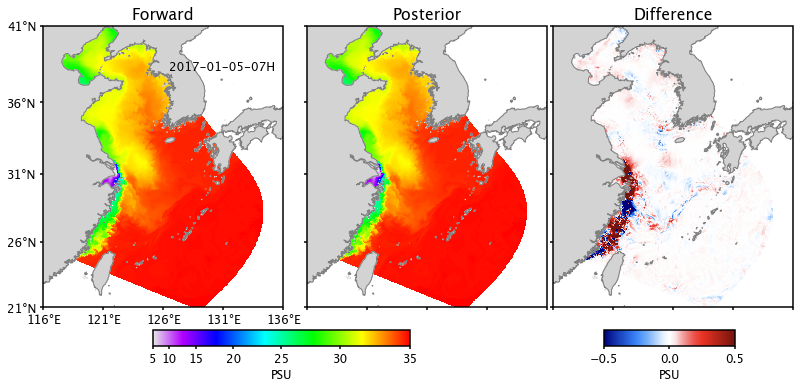

In [105]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 2
iwnl = 0
iwda = 0
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','ks',]:
for area in ['all','cre']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 27
        vmax_sst = 32
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 32
        vmax_sst = 34
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 1
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 15
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 34
        vmax_sst = 35
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 5
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.93

    for it in range(1,len(dab_Vars[area][iwda].ocean_time)):
    # for it in range(2):
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                       0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                      cmap = my_sst, norm = norm,
                      # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Forward',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(dab_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(dab_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(dab_Vars[area][iwda].lon,dab_Vars[area][iwda].lat,
                       dab_Vars[area][iwda].value[it,:,:],
                   cmap = my_sst, norm = norm,
                   # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('PSU',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(dab_Vars[area][iwda].lon,dab_Vars[area][iwda].lat,
                       dab_Vars[area][iwda].value[it,:,:]-
                           0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('PSU',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        
        plt.savefig('./fig_evolution/exp_adj_ini/prior/sss/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

In [ ]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 2
iwnl = 0
iwda = 2
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','ks',]:
for area in ['all','cre']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 27
        vmax_sst = 32
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 32
        vmax_sst = 34
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 1
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 15
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 34
        vmax_sst = 35
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 5
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.93

    # for it in range(1,len(daa_Vars[area][iwda].ocean_time)):
    # for it in range(1,2):
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                       0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                      cmap = my_sst, norm = norm,
                      # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Forward',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                       daa_Vars[area][iwda].value[it,:,:],
                   cmap = my_sst, norm = norm,
                   # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior exp_adj_ini_nud',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('PSU',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                       daa_Vars[area][iwda].value[it,:,:]-
                           0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('PSU',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        
        plt.savefig('./fig_evolution/exp_adj_ini_nud/post/sss/%s/%s_1.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_27303/3525400324.py:129: RuntimeWarning: Mean of empty slice
  np.nanmean( nl_Vars[area][iwnl].value,
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_27303/3525400324.py:158: RuntimeWarning: Mean of empty slice
  np.nanmean(daa_Vars[area][iwda].value,axis=0),
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_27303/3525400324.py:195: RuntimeWarning: Mean of empty slice
  np.nanmean(
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


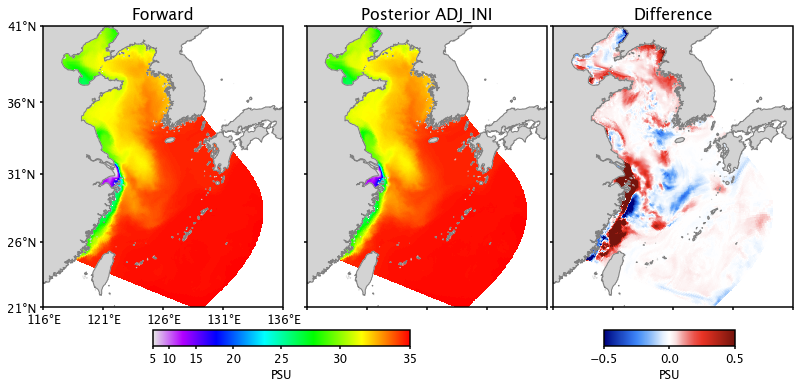

In [17]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 2
iwnl = 0
iwda = 0
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','ks',]:
for area in ['all']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 27
        vmax_sst = 32
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 32
        vmax_sst = 34
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 1
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 15
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 34
        vmax_sst = 35
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 5
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.93

    fig = plt.figure(figsize=figsize, constrained_layout = True)
    #===============================observation spatial pattern
    ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                  np.nanmean( nl_Vars[area][iwnl].value,
                             axis = 0),
                  cmap = my_sst, norm = norm,
                  # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Forward',fontsize=16)
    # ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
    #===============================posterior spatial pattern
    ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)

    c2=ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                   np.nanmean(daa_Vars[area][iwda].value,axis=0),
               cmap = my_sst, norm = norm,
               # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Posterior ADJ_INI',fontsize=16)

            #==== colobar

    position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
    cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    cb.set_label('PSU',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    cb3 = ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                  np.nanmean(
                      daa_Vars[area][iwda].value[1:,:,:]-
                       np.array(
                                [0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]) for it in range(1,len(daa_Vars[area][iwda].ocean_time))]
                            ), axis = 0),
               cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Difference',fontsize=16)
        #---- colrbar

    position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


    cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    cb2.set_label('PSU',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)

    #===============================observation spatial pattern

    plt.savefig('./fig_evolution/exp_adj_ini/post/sss/%s_roms_i4dvar_contrast_adj_ini_forw.vs.post_timemean2.jpeg'%(area),dpi=1200,bbox_inches='tight')
    # plt.close()

In [ ]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 2
iwnl = 0
iwda = 1
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','ks',]:
for area in ['all','cre']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 27
        vmax_sst = 32
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 32
        vmax_sst = 34
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 1
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 15
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 34
        vmax_sst = 35
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 5
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.93

    fig = plt.figure(figsize=figsize, constrained_layout = True)
    #===============================observation spatial pattern
    ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                  np.nanmean( nl_Vars[area][iwnl].value,
                             axis = 0),
                  cmap = my_sst, norm = norm,
                  # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Forward',fontsize=16)
    # ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
    #===============================posterior spatial pattern
    ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)

    c2=ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                   np.nanmean(daa_Vars[area][iwda].value,axis=0),
               cmap = my_sst, norm = norm,
               # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Posterior exp_adj_ini_nud',fontsize=16)

            #==== colobar

    position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
    cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    cb.set_label('PSU',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    cb3 = ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                  np.nanmean(
                      daa_Vars[area][iwda].value[1:,:,:]-
                       np.array(
                                [0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]) for it in range(1,len(daa_Vars[area][iwda].ocean_time))]
                            ), axis = 0),
               cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Difference',fontsize=16)
        #---- colrbar

    position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


    cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    cb2.set_label('PSU',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)

    #===============================observation spatial pattern

    # plt.savefig('./fig_evolution/exp_adj_ini_nud/post/sss/%s_roms_i4dvar_contrast_adj_ini_forw.vs.post_timemean.jpeg'%(area),dpi=1200,bbox_inches='tight')
    # plt.close()

In [20]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 2
iwnl = 0
iwda = 0
iwda1 = 1
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','ks',]:
for area in ['all','cre']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 27
        vmax_sst = 32
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 32
        vmax_sst = 34
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 1
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 15
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 34
        vmax_sst = 35
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 5
        vmax_sst = 35
        norm = colors.FuncNorm((_forward, _inverse), vmin=vmin_sst, vmax=vmax_sst)
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 5
        bc = 0.93

    for it in range(0,len(dab_Vars[area][iwda].ocean_time)):
    # for it in range(2):
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                       daa_Vars[area][iwda].value[it,:,:],
                      cmap = my_sst, norm = norm,
                      # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior exp_adj_ini',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(dab_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(dab_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(dab_Vars[area][iwda].lon,dab_Vars[area][iwda].lat,
                       daa_Vars[area][iwda1].value[it,:,:],
                   cmap = my_sst, norm = norm,
                   # cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior exp_adj_ini_nud',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('PSU',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(dab_Vars[area][iwda].lon,dab_Vars[area][iwda].lat,
                       daa_Vars[area][iwda1].value[it,:,:]-
                           daa_Vars[area][iwda].value[it,:,:],
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('PSU',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        
        plt.savefig('./fig_contrast/adj_ini.vs.adj_ini_nud/post/sss/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

In [1]:
1483401600/86400

17169.0

In [104]:
(17169 - 17532)*30*24

-261360

In [106]:
2880/24/60

2.0

In [4]:
60*24*365








525600